# Monte Carlo Assignment

In [5]:
import scipy as s
import numpy as np
import matplotlib.pyplot as plt
import time
import numba
from numba import jit

### Assignment Part 1: Development of the Monte Carlo Code



In [6]:
# Define all the necessary functions
@jit(nopython = True)
def LJ_real(sigma, epsi, r):
    Energy = 4*epsi*((sigma/r)**12-(sigma/r)**6);
    return Energy;
@jit(nopython = True)
def Mixing (sigma_1,sigma_2,epsi_1,epsi_2):
    sigma_final = (sigma_1+sigma_2)/2;
    epsi_final  = (epsi_1*epsi_2)**0.5;
    return sigma_final, epsi_final;

@jit(nopython = True)
def PBC (x2,y2,z2,x1 ,y1 ,z1 , Lx, Ly, Lz):  
    x = (x2 - x1) - Lx*np.round((x2 - x1)/Lx);   # for dx = dx - nearest_int(dx/L)
    y = (y2 - y1) - Ly*np.round((x2 - x1)/Ly);
    z = (z2 - z1) - Lz*np.round((x2 - x1)/Lz); 
    
    coordinate = np.array([x,y,z]);
    return coordinate; 

@jit(nopython = True)
def Distance (A):
        sum = 0;
        for i in range(0,3):
            sum = sum + (A[i])**2;
        return s.sqrt(sum);
    
# Defining function to calculate the d(U)/dr

@jit(nopython = True)
def Dudr (sigma, epsi, r):
    Energy = -24*(epsi)*(2*(sigma/r)**12-(sigma/r)**6); # Calculation of the force // calculates fi*ri 
    return Energy;    

# Random Number Generator.

@jit(nopython = True)
def ran_num_gen(A):
    a = np.random.rand(A);
    a = 2*a-1;  # this is done to bring the range of Random number between -1 to 1
    return a;

@jit(nopython = True)
def U_tail_Corr(sigma,epsi,Rcut):
    U = 8/3*s.pi*epsi*(1/3*(sigma/Rcut)**9 - (sigma/Rcut)**3);       # Rho* sigma^3 has been taken approx =1
    return U;

@jit(nopython = True)    
def P_tail_Corr(sigma,epsi,Rcut):                                               # Rho* sigma^3 has been taken approx =1
    P = 16/3*s.pi*epsi*(2/3*(sigma/Rcut)**9 - (sigma/Rcut)**3);                 # Tail Correction for Du/
    return P;

# to define the writing file remember to tranpose my array before using this function.
def write_xyz_traj(r, Npart, file_name):
	'''
		This function appends a frame to the end of a xyz file. 
		
		: r : 			position of the particles in the form of [[x1,y1,z1],[x2,y2,z2] ... [xN,yN,zN]]
		: Npart :		number of particles (int)
		: filename :	name of the trajectory file where the frame gets appended (str)

	'''
	output_box0 = open(file_name + '.xyz', 'a')
	output_box0.write('%0.0i\n\n' % Npart)
	[output_box0.write('%s\t%0.5f\t%0.5f\t%0.5f\n' % ("C", r[i, 0], r[i, 1], r[i, 2])) for i in range(0, Npart)]
	output_box0.close()
 
def read_xyz_trj(file_name):

    xyz_file = open(file_name, 'r')

    frame = 0
    xyz = {}
    READING=True
    while READING:
        try:
            nparts = int(xyz_file.readline())
            xyz_file.readline()
            xyz[frame] = np.zeros([nparts, 3])
            for k in range(0, nparts):
                line = xyz_file.readline()
                line = line.split()
                xyz[frame][k, 0] = line[1]
                xyz[frame][k, 1] = line[2]
                xyz[frame][k, 2] = line[3]
            frame += 1
        except:
            print("Reach end of '" + file_name + "'")
            READING=False

    return xyz
    
    

In [7]:
# Answer to Question 4:
def rdf(xyz, LxLyLz, n_bins=100, r_range=(0.01, 10.0)):
    '''
    rarial pair distribution function

    :param xyz: coordinates in xyz format per frame
    :param LxLyLz: box length in vector format
    :param n_bins: number of bins
    :param r_range: range on which to compute rdf
    :return:
    '''

    g_r, edges = np.histogram([0], bins=n_bins, range=r_range)
    g_r[0] = 0
    g_r = g_r.astype(np.float64)
    rho = 0

    for i, xyz_i in enumerate(xyz):
        xyz_j = np.vstack([xyz[:i], xyz[i + 1:]])
        d = np.abs(xyz_i - xyz_j)
        d = np.where(d > 0.5 * LxLyLz, LxLyLz - d, d)
        d = np.sqrt(np.sum(d ** 2, axis=-1))
        temp_g_r, _ = np.histogram(d, bins=n_bins, range=r_range)
        g_r += temp_g_r

    rho += (i + 1) / np.prod(LxLyLz)
    r = 0.5 * (edges[1:] + edges[:-1])
    V = 4./3. * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
    norm = rho * i
    g_r /= norm * V

    return r, g_r


In [8]:
# Defining all the necessary constants
Kb = 1.38*10**-23;
eps = 1.7*10**-21;

#### Question 1.1 

In [9]:
# Defining the function for calculation of the total energy
@jit(nopython = True)
def Etot (Natom, sigma, epsi, traj, Rcut, Lx, Ly, Lz): 
    '''
    Calculates the total energy of a frame. function nameis kept different from the one in the assignment (totalEnergy).
    
    param:
    Natom: total atoms
    sigma, eplsilon are written as sigma and epsi 
    traj: particle trajectory for the frame.
    box dimenstions as Lx, Ly and Lz.
    Rcut is cutoff radius
    
    output:
    gives the energy of the system as same units as epslion.
    '''
    
    U_adder = 0;  # to store the Total Energy Computed

 # Now setting up a loop for computing nC2 combinations.

    for i in range(0,Natom-1):  
        
        for j in range(i+1,Natom):
            
    # we store the values of the the trajectores of the two atoms in z=x, y, z so that it is more convinient to write the code
    # although it uses up a lot of the space for the Memory.
                  
            x1 = traj[0][i];
            y1 = traj[1][i];
            z1 = traj[2][i];
            
     # Similarly we put for atom 2
            
            x2 = traj[0][j];
            y2 = traj[1][j];
            z2 = traj[2][j];  
            
  # Getting done with the PBC Stuff

            tr2 = np.array([x2, y2, z2]);
            tr1 = np.array([x1, y1, z1]);
            dist = np.abs(tr2 - tr1);
            lxlylz = np.array([Lx, Ly, Lz]);
            dist = np.where(dist > 0.5 * lxlylz, lxlylz - dist, dist);
        
    # now we calculate the Distance between the two particles
            
            R = (dist[0]**2 + dist[1]**2 + dist[2]**2)**0.5;
            
    #  Apply the Cutoff Radius Method  and shift the energy potentials properly so that they are no discontinuous.  
        
            if (R <= Rcut):
                
                U_adder = U_adder + LJ_real(sigma,epsi,R) ; 
       
        U_adder = U_adder + (Natom/(Lx*Ly*Lz))*8/3*np.pi*epsi*(sigma**3)*(1/3*(sigma/Rcut)**9 - (sigma/Rcut)**3); # Tail correction factor is an approximation
    return U_adder;



#### Question 1.2

In [10]:
# Calculation for a single particle
@jit(nopython = True)
def Etot_1(Natom,sigma,epsi, traj, Rcut, Lx, Ly, Lz, x, y, z): 
    '''
    Calculates the single particle energy. function name is kept different from the one in the assignment (singleParticleEnergy).
    
    param:
    Natom: total atoms
    sigma, eplsilon are written as sigma and epsi 
    box dimenstions as Lx, Ly and Lz.
    traj: particle traj for the frame 
    Rcut is cutoff radius
    x,y,z is the particle coord whose energy is computed
    
    output:
    gives the energy of the system as same units as epslion.
    
    Note: tail correction not done as it only adds to computation time and has no use since it gets cancelled anyway while 
    calculating acceptance criteria. (U2-U1)/KbT
    
    '''
    
    U_adder = 0;  # to store the Total Energy Computed     
    
    
    
    for j in range(0,Natom):       
            
        x2 = traj[0][j];
        y2 = traj[1][j];
        z2 = traj[2][j];
         
        if (x == x2):    # if the coordinate matches then theat iteration is skipped.
                continue;
                
  # Getting done with the PBC Stuff
        x1 = np.abs(x2 - x) - Lx*np.round(np.abs(x2 - x)/Lx);   # for dx = dx - nearest_int(dx/L)
        y1 = np.abs(y2 - y) - Ly*np.round(np.abs(y2 - y)/Ly);
        z1 = np.abs(z2 - z) - Lz*np.round(np.abs(z2 - z)/Lz); 
            
    # now we calculate the Distance between the two particles 

        R = np.sqrt(x1**2 + y1**2 + z1**2);  
            
    #  Apply the Cutoff Radius Method  and shift the energy potentials properly so that they are no discontinuous.  
        
        if (R <= Rcut):
                
            U_adder = U_adder + LJ_real(sigma,epsi,R) ;
    
    return U_adder;
        


#### Question 1.3

In [11]:
# To calculate the real pressure
@jit(nopython = True)
def Etot_P(T, Natom, sigma, epsi, traj, Rcut, Lx, Ly, Lz): 
    '''
    Computes the pressure of the system. arbritrary name given as no name mentioned in assgn.
    
    param:
    T: system temperature
    Natom: No of atoms
    sigma and epsi are sigma and epsilon resp.
    traj: particle trajectory
    Rcut: cutoff
    Lx, Ly, Lz: box dimensions
    
    
    Output:
    Pressure in Pascals

    '''
    
    U_adder = 0;  # to store the Total Energy Computed

 # Now setting up a loop for computing nC2 combinations.

    for i in range(0,Natom-1):  
        
        for j in range(i+1,Natom):
            
    # we store the values of the the trajectores of the two atoms in z=x, y, z so that it is more convinient to write the code
    # although it uses up a lot of the space for the Memory.
                  
            x1 = traj[0][i];
            y1 = traj[1][i];
            z1 = traj[2][i];
            
     # Similarly we put for atom 2
            
            x2 = traj[0][j];
            y2 = traj[1][j];
            z2 = traj[2][j];
    
    
     
            R = 0;   
  # Getting done with the PBC Stuff

            x = np.abs(x2 - x1) - Lx*np.round(np.abs(x2 - x1)/Lx);   # for dx = dx - nearest_int(dx/L)
            y = np.abs(y2 - y1) - Ly*np.round(np.abs(y2 - y1)/Ly);
            z = np.abs(z2 - z1) - Lz*np.round(np.abs(z2 - z1)/Lz); 
            
    # now we calculate the Distance between the two particles 

            R = np.sqrt(x**2 + y**2 + z**2); 
            if(R <= Rcut):
    #  Apply the Cutoff Radius Method  and shift the energy potentials properly so that they are no discontinuous.  
                 
                U_adder = U_adder + Dudr(sigma,epsi,R); #
    
    P_reduced = 2/2*Natom/(Lx*Ly*Lz)*(Kb*T)/eps- 1/(3*Lx*Ly*Lz)*((U_adder));  #  1 is taken as epsion is Kelvin and not joules '-' sign is taen cae in the function definition
    P_Pascal = P_reduced*eps /(10**-30);    
    return P_Pascal;

    


#### Question 1.4


In [12]:
#Just perform the equilibriation and dont store the system enegy and pressure and not compute it as well.

def translate_EQ(T, Natom, sigma, epsi, traj, Rcut, Lx, Ly, Lz, step_size, run):
    '''
    Performs the MC move for the said number of steps.
    "Does Not" compute the Total system energy or Pressure. Just designed to perform equilibration and not for sampling. 
    
      param:
    T: system temperature
    Natom: No of atoms
    sigma and epsi are sigma and epsilon resp.
    traj: particle trajectory
    Rcut: cutoff
    Lx, Ly, Lz: box dimensions
    step_size: adjusted according to maximum displacement in Lx, Ly and Lz.
    run: Number of cycles
    
    Output:
    Relaxed trajectory
    
    '''
    a = traj;
    relaxation = [];                        #To store the accept move's energy
    all_en = []; 
    all_p = [];
    # To store any energy compute rejected as well as accepted.
    # Randomly select an atom for the box.
        
    for i in range(0,run): 
        A = np.random.rand(1);       #(Selects a number from 0 to 1 and then uses this selection to pick a random particle) 
        v = (Natom-1)*A[0];                 # pick a random molecule from the array of the trajectories
        Select = int(v);                    # Convent into an array indice
        
        # Compute the old Energy of the Particle
        e_old_part = Etot_1(Natom, sigma, epsi, a, Rcut, Lx, Ly, Lz, a[0][Select], a[1][Select], a[2][Select]);
        
        # Extract the Coordinates of the randomly selected atom and move it.
        move = ran_num_gen(3)*step_size; 
        # Save to old configuration   
        tempx = a[0][Select];
        tempy = a[1][Select];
        tempz = a[2][Select];    
    
        # Change the configuration
        a[0][Select] = a[0][Select] + move[0];
        a[1][Select] = a[1][Select] + move[1];
        a[2][Select] = a[2][Select] + move[2];
        
        # Calculate the new energy of the particle
        e_new_part = Etot_1(Natom, sigma, epsi, a, Rcut, Lx, Ly, Lz, a[0][Select], a[1][Select], a[2][Select]);  
        
        #Compute the Probability
        DU = e_new_part - e_old_part;
        flag = s.exp((-DU*eps)/(Kb*T));
        p = min(flag,1);
        
        # Accept or Reject
        if (p >= float(np.random.rand(1))):
            continue;     # This was simply used to get rid of an "if" statement.
        
        # This to bring the old configuration back if the move is rejected.
        a[0][Select] = tempx;
        a[1][Select] = tempy;
        a[2][Select] = tempz;
          
    return (a);
 # will just return the final equilibrium configuration

In [13]:
def translate_Sample(T, Natom, sigma, epsi, traj, Rcut, Lx, Ly, Lz, step_size,run):
    '''
    Performs the MC move for the said number of steps.
    "Computes" the Total system energy or Pressure. Just designed to perform equilibration and also sampling. 
    
    param:
    T: system temperature
    Natom: No of atoms
    sigma and epsi are sigma and epsilon resp.
    traj: particle trajectory
    Rcut: cutoff
    Lx, Ly, Lz: box dimensions
    step_size: adjusted according to maximum displacementin Lx, Ly and Lz.
    run: Number of cycles
    
    Output:
    energy of accepted steps, 
    energy of all the steps, 
    pressure of al steps and final equilibrated frame.
    
    Note: as per the assignment, a function was to be defined for just a single translation move and this function had to
    be looped for the required number of cycles.
    This has not been followed as repetitive parsing of the trajectory array into a function within a loop
    was prohibited for my jupyter notebook for 32bit processor.
    Hence the function was written in this manner.
    
    '''
    a = traj;
    relaxation = [];                        #To store the accept move's energy
    all_en = []; 
    all_p = [];
    # To store any energy compute rejected as well as accepted.
    # Randomly select an atom for the box.
        
    for i in range(0,run): 
        A = np.random.rand(1);       #(Selects a number from 0 to 1 and then uses this selection to pick a random particle) 
        v = (Natom-1)*A[0];                 # pick a random molecule from the array of the trajectories
        Select = int(v);                    # Convent into an array indice
        
        # Compute the old Energy of the Particle
        e_old_part = Etot_1(Natom, sigma, epsi, a, Rcut, Lx, Ly, Lz, a[0][Select], a[1][Select], a[2][Select]);
        
        # Extract the Coordinates of the randomly selected atom and move it.
        move = ran_num_gen(3)*step_size; 
        # Save to old configuration   
        tempx = a[0][Select];
        tempy = a[1][Select];
        tempz = a[2][Select];    
    
        # Change the configuration
        a[0][Select] = a[0][Select] + move[0];
        a[1][Select] = a[1][Select] + move[1];
        a[2][Select] = a[2][Select] + move[2];
        
        # Calculate the new energy of the particle
        e_new_part = Etot_1(Natom, sigma, epsi, a, Rcut, Lx, Ly, Lz, a[0][Select], a[1][Select], a[2][Select]);
        
        # Store all the energies even if rejected
        e_new = Etot(Natom, sigma, epsi, a, Rcut, Lx, Ly, Lz);
        all_en.append(e_new);   
        
        Pressure  = Etot_P(T, Natom, sigma, epsi, a, Rcut, Lx, Ly, Lz);
        all_p.append(Pressure);
        
        #Compute the Probability
        DU = e_new_part - e_old_part;
        flag = s.exp((-DU*eps)/(Kb*T));
        p = min(flag,1);
        
        # Accept or Reject
        if (p >= float(np.random.rand(1))):
            relaxation.append(e_new);
            
            # Computes and stores the pressure for the current configuration
            
            continue;     # This was simply used to get rid of an "if" statement.
        
        # This to bring the old configuration back if the move is rejected.
        a[0][Select] = tempx;
        a[1][Select] = tempy;
        a[2][Select] = tempz;
          
    return (relaxation, all_en, all_p, a);
 

#### Question 1.5

In [14]:
def startConf(T, Npart, sigma, epsi, Rcut, Lx, Ly, Lz, step_size, run):
    '''
    Creates a initial system, with randomly placed particles and removes closely placed atoms.
    
    param:
    T: system temperature
    Npart: No of atoms
    sigma and epsi are sigma and epsilon resp.
    Rcut: cutoff
    Lx, Ly, Lz: box dimensions
    step_size: adjusted according to maximum displacemet in Lx, Ly and Lz.
    run: Number of cycles for removing overlaps.
    
    
    Output:
    the equilibrated frame.
    
    Note: Does not sample when it is equilibrating. 
    
    '''
    
    traj_coord = [[],[],[]]; # to store the  particle trajectories
    part_count = 1;

    #~~~~~~~~~~~~~~~~~~~Create the first Particle~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    seedx = float(Lx/2*ran_num_gen(1));  # ran_num_gen creates a value between -1 to 1 and I scale it to -L/2 to +L/2
    seedy = float(Ly/2*ran_num_gen(1));  # to create a new particle
    seedz = float(Lz/2*ran_num_gen(1));   
        
    traj_coord[0].append(seedx);
    traj_coord[1].append(seedy);
    traj_coord[2].append(seedz);
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    while (part_count <= Npart-1): # -1 taken as we create the first particle outside the loop 
            
        x1 = float(Lx/2*ran_num_gen(1));  # ran_num_gen creates a value between -1 to 1 and I scale it to -L/2 to +L/2
        y1 = float(Ly/2*ran_num_gen(1));  # to create a new particle
        z1 = float(Lz/2*ran_num_gen(1));
            
            
        flag =0;
        for i in range(0,part_count):  
                
            x = traj_coord[0][i-1];
            y = traj_coord[1][i-1];
            z = traj_coord[2][i-1];
            
            d = s.sqrt((x-x1)**2 + (y-y1)**2 + (z-z1)**2);
            
            if (d <= 3): # to maintain a distance of Atleast 3 angtrom 
                flag = 1;    
            
        if (flag == 0):
            # Store the trajectories
            traj_coord[0].append(x1);
            traj_coord[1].append(y1);
            traj_coord[2].append(z1);
            part_count += 1; 
    
    traj_coord = np.array(traj_coord);
    
    # Relax the Structure a bit to remove any coinsiding atoms.
    a = translate_EQ(T, Npart, sigma, epsi, traj_coord, Rcut, Lx, Ly, Lz, step_size,run); 
    return a;

In [34]:
# this is just kept to test whether the code is woring condition or not.
# If there is serious an error here, the further code will not work.
#The time in sec tell you the til for 500 MC cycles set the runs accordingly 

a = startConf(150, 362, 3.73, 148*Kb/eps, 14, 30, 30, 30, 0.5, 100);
t = time.time();
a1 = translate_Sample(150, 362, 3.73, 148*Kb/eps,a, 14, 30, 30, 30, 0.5, 500)
print("Time in sec ", time.time() - t);


Time in sec  44.269519090652466


#### Question 1.6

In [17]:
# function to perform the averages
@jit(nopython = True)
def averages(A):
    '''
    Computes the averages
    params:
    The array of the variables for the average calculation.
    
    Output:
    average value
    '''
    sum = 0;
    for i in range(len(A)):
        sum = sum +A[i-1];
    return (sum/len(A));            
        

#### Question 1.7

In [18]:
#Finally Putting all the System Together into a NVT_MC Model

def Monte_Carlo_NVT(Npart, T, sigma, epsi, Rcut, Lx, Ly, Lz, step_size, run, run1):
    '''
    Has two parts: create configuration and equilibrates, and then smaples.
    
    param:
    T: system temperature
    Npart: No of atoms
    sigma and epsi are sigma and epsilon resp.
    Rcut: cutoff
    Lx, Ly, Lz: box dimensions
    step_size: adjusted according to maximum in Lx, Ly and Lz, for stepsize of x the maximum disp is x*3**0.5.
    
    run: Number of cycles for removing overlaps  and equilibration.(put this a larger value say 500000)
    run1: Sampling runs (keep this less but sufficient enough say 50000 as this taes a lot of time) 
    
    
    Output:
    Avg_P: Average pressure
    Avg_E: Average energy
    Pressure_arr: Pressure array of all frames.
    Energy_arr: the energy array of all frames (accepted or rejected)
    Relaxation_arr: the energy array of the accepted frames 
    
    '''
    # create conf and equilibrate it.
    coord_arr = startConf(T, Npart, sigma, epsi, Rcut, Lx, Ly, Lz, step_size, run);
    
    # Now do sampling on the equilibriated system.
    
    Data  = translate_Sample(T, Npart, sigma, epsi, coord_arr, Rcut, Lx, Ly, Lz, step_size, run1);
    
    Pressure_arr = np.array(Data[2]);
    Energy_arr = np.array(Data[1]);
    Relaxation_arr = np.array(Data[0]);
    
    Avg_P = averages(Pressure_arr);
    Avg_E = averages(Energy_arr);
    Acceptance = len(Relaxation_arr)/len(Energy_arr);
    
    return Avg_P, Avg_E,Pressure_arr, Energy_arr, Relaxation_arr, Acceptance;
        

### Question 2.1 Application of MC_NVT Code

#### Question 2.1

In [35]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Insert the Input Parameters Here~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
acceptance = []
j = 0
for i in range(0,12):
    j = j + 0.25;    
    a = Monte_Carlo_NVT(362, 150, 3.73, 148*Kb/eps, 14, 30, 30, 30,j , 200000, 1000)
    rate = a[5];
    acceptance.append(rate);

11


KeyboardInterrupt: 

Text(0.5,1,'The Variation of the Acceptance rate with the step size ')

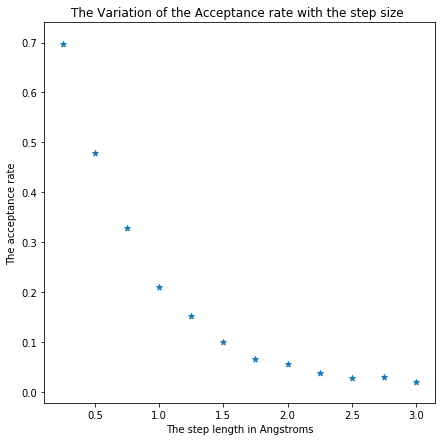

In [21]:
# PLot for the variation of the acceptance with the step size
plt.figure(figsize = (7,7))
plt.scatter ([ 0.25, 0.5, 0.75, 1.00, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3],acceptance, marker = "*");
plt.ylabel("The acceptance rate")
plt.xlabel("The step length in Angstroms")
plt.title("The Variation of the Acceptance rate with the step size ")


#### Question 2.2

In [28]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Insert the Input Parameters Here~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
acceptance = [];
j = 0
for i in range(0,36):
    j = j + 0.5;    
    a = Monte_Carlo_NVT(153, 400, 3.73, 148*Kb/eps, 30, 75, 75, 75, j , 100000, 10000)
    rate = a[5];
    acceptance.append(rate);

runtime 149.88283896446228 rate 0.9811
runtime 153.8870210647583 rate 0.9764
runtime 153.0754852294922 rate 0.9535
runtime 155.57639861106873 rate 0.9482
runtime 161.8747787475586 rate 0.9356
runtime 217.95335817337036 rate 0.9275
runtime 213.03645277023315 rate 0.9204
runtime 192.05660319328308 rate 0.919
runtime 184.75244164466858 rate 0.9064
runtime 179.10648941993713 rate 0.9087
runtime 174.86131811141968 rate 0.8997
runtime 171.70640420913696 rate 0.8962
runtime 153.8754849433899 rate 0.888
runtime 160.01684021949768 rate 0.8963
runtime 167.149272441864 rate 0.8958
runtime 167.43908166885376 rate 0.8931
runtime 164.1636893749237 rate 0.8958
runtime 167.6734549999237 rate 0.8884
runtime 172.27742981910706 rate 0.8945
runtime 167.39116644859314 rate 0.8877
runtime 172.85397791862488 rate 0.8946
runtime 170.1289086341858 rate 0.8872
runtime 175.54584765434265 rate 0.8807
runtime 172.16215562820435 rate 0.8944
runtime 168.01236605644226 rate 0.8821
runtime 162.72425961494446 rate 0.88

Text(0.5,1,'The Variation of the Acceptance rate with the step size ')

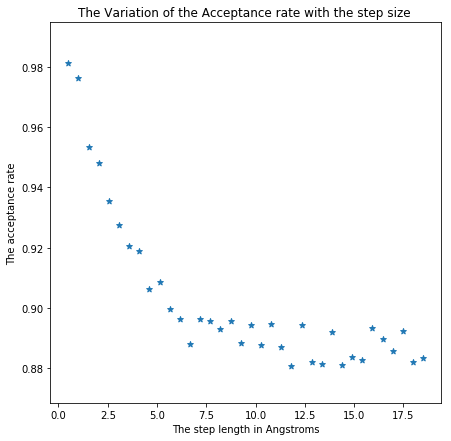

In [31]:
# PLot for the variation of the acceptance with the step size
plt.figure(figsize = (7,7))
plt.scatter (np.linspace(0.5,18.5,36),acceptance, marker = "*" );
plt.ylabel("The acceptance rate")
plt.xlabel("The step length in Angstroms")
plt.title("The Variation of the Acceptance rate with the step size ")

#### Question 2.3

In [151]:
# Energy calculation using 0.5 Angstrom Step size 
ab = Monte_Carlo_NVT(362, 150, 3.73, 148*Kb/eps, 14, 30, 30, 30, 0.5 , 2500, 100000);

11482.077052116394


In [23]:
ener = Monte_Carlo_NVT(362, 150, 3.73, 148*Kb/eps, 14, 30, 30, 30, 0.5 , 450000, 50000);

In [153]:
print("The energy is in Kelvin is "ener[1]*eps/Kb);

-248683.98504662796


Text(0.5,1,' To study the steps needed to reach equilibrium')

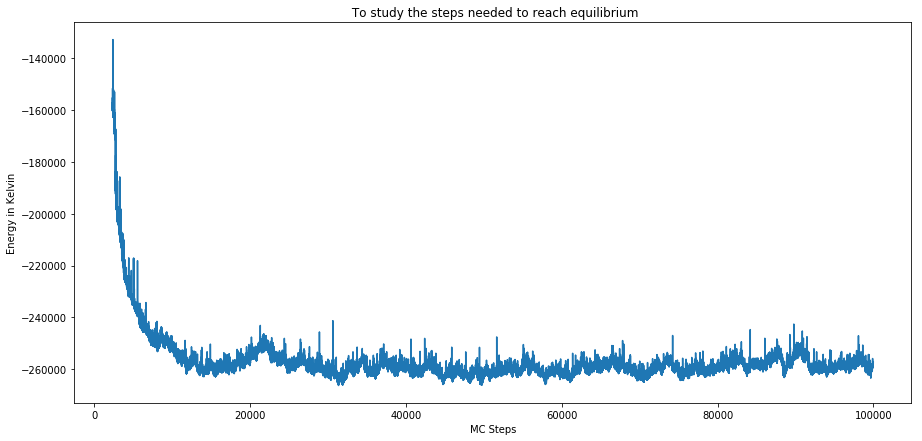

In [152]:
# 2300 cells have been readjusted (0 to 2300 indices are hidden) for proper visibility. set your values according to the run
plt.figure(figsize = (15,7))
plt.plot(np.linspace(2300,len(ab[3]),(len(ab[3])-2300)), ab[3][2300: len(ab[3])]*eps/Kb, ms = '1' );
plt.ylabel("Energy in Kelvin");
plt.xlabel("MC Steps");
plt.title(" To study the steps needed to reach equilibrium")

In [30]:
# error Calculation
sum = 0;
Avg = ener[1];

for i in range (len(ener[3])):
    sum  += (ener[3][i-1] - Avg)**2

Std_Dev = np.sqrt(sum/len(ener[3]));
print("Error in the code is","+-",Std_Dev*eps/Kb, " i.e.the standard deviation" );    

Error in the code is +- 2311.4395566647827  i.e.the standard deviation


#### Question 3.1

In [37]:

# create a smapling fucntion which writes the trajectory and put it in a new MC_NVT function.
def translate_Sample_write(T, Natom, sigma, epsi, traj, Rcut, Lx, Ly, Lz, step_size,run, file_name):
    '''
    Exactly same function as translate_Sample function except that it has a writing function which writes the accepted steps

    '''
    a = traj;
    relaxation = [];                        #To store the accept move's energy
    all_en = []; 
    all_p = [];
    # To store any energy compute rejected as well as accepted.
    # Randomly select an atom for the box.
        
    for i in range(0,run): 
        A = np.random.rand(1);       #(Selects a number from 0 to 1 and then uses this selection to pick a random particle) 
        v = (Natom-1)*A[0];                 # pick a random molecule from the array of the trajectories
        Select = int(v);                    # Convent into an array indice
        
        # Compute the old Energy of the Particle
        e_old_part = Etot_1(Natom, sigma, epsi, a, Rcut, Lx, Ly, Lz, a[0][Select], a[1][Select], a[2][Select]);
        
        # Extract the Coordinates of the randomly selected atom and move it.
        move = ran_num_gen(3)*step_size; 
        # Save to old configuration   
        tempx = a[0][Select];
        tempy = a[1][Select];
        tempz = a[2][Select];    
    
        # Change the configuration
        a[0][Select] = a[0][Select] + move[0];
        a[1][Select] = a[1][Select] + move[1];
        a[2][Select] = a[2][Select] + move[2];
        
        # Calculate the new energy of the particle
        e_new_part = Etot_1(Natom, sigma, epsi, a, Rcut, Lx, Ly, Lz, a[0][Select], a[1][Select], a[2][Select]);
        
        # Store all the energies even if rejected
        e_new = Etot(Natom, sigma, epsi, a, Rcut, Lx, Ly, Lz)
        all_en.append(e_new);   
        
        Pressure  = Etot_P(T, Natom, sigma, epsi, a, Rcut, Lx, Ly, Lz);
        all_p.append(Pressure);
        
        #Compute the Probability
        DU = e_new_part - e_old_part;
        flag = s.exp((-DU*eps)/(Kb*T));
        p = min(flag,1);
        
        # Accept or Reject
        if (p >= float(np.random.rand(1))):
            relaxation.append(e_new);
            temp = a.transpose();
            write_xyz_traj(temp, Natom, file_name)
            
            # Computes and stores the pressure for the current configuration
            
            continue;     # This was simply used to get rid of an "if" statement.
        
        # This to bring the old configuration back if the move is rejected.
        a[0][Select] = tempx;
        a[1][Select] = tempy;
        a[2][Select] = tempz;
          
    return (relaxation, all_en, all_p, a);
 
# putting the new function in the new MC function

def Monte_Carlo_NVT_write(Npart, T, sigma, epsi, Rcut, Lx, Ly, Lz, step_size, run, run1, filename):
    '''
    Has two parts: create configuration and equilibrates, and then samples.
    
    Same as the previous MC_NVT function but writes trajectories of the accepted steps in a file.
    
    param:
    T: system temperature
    Npart: No of atoms
    sigma and epsi are sigma and epsilon resp.
    Rcut: cutoff
    Lx, Ly, Lz: box dimensions
    step_size: adjusted according to maximum in Lx, Ly and Lz, for stepsize of x the maximum disp is x*3**0.5.
    
    run: Number of cycles for removing overlaps  and equilibration.(put this a larger value say 500000)
    run1: Sampling runs (keep this less but sufficient enough say 50000 as this takes a lot of time) 
    filename: filename of the file to store data
    (Note: dont put .xyz after file name, the write function does that implicitly)
    
    Output:
    Avg_P: Average pressure
    Avg_E: Average energy
    Pressure_arr: Pressure array of all frames.
    Energy_arr: the energy array of all frames (accepted or rejected)
    Relaxation_arr: the energy array of the accepted frames 
    '''
    
    coord_arr = startConf(T, Npart, sigma, epsi, Rcut, Lx, Ly, Lz, step_size, run);
    
    # Now do sampling on the equilibriated system and write it as well
    
    Data  = translate_Sample_write(T, Npart, sigma, epsi, coord_arr, Rcut, Lx, Ly, Lz, step_size, run1, filename);
    
    Pressure_arr = np.array(Data[2]);
    Energy_arr = np.array(Data[1]);
    Relaxation_arr = np.array(Data[0]);
    
    Avg_P = averages(Pressure_arr);
    Avg_E = averages(Energy_arr);
    
    return Avg_P, Avg_E,Pressure_arr, Energy_arr, Relaxation_arr;
        

#### Case 1:

In [105]:
# T = 100 density  = 358.4 
a1 = Monte_Carlo_NVT_write(362, 200, 3.73, 148*Kb/eps, 14, 30, 30, 30, 0.5 , 450000, 50000,'ch4_358.4_100');

In [106]:
print(" The pressure in atm=", a1[0]*1.013/100000);

 The pressure in atm= 432.43625554739265


In [107]:
# T = 200 density  = 358.4 
a2 = Monte_Carlo_NVT_write(362, 200, 3.73, 148*Kb/eps, 14, 30, 30, 30, 0.5 , 450000, 50000,'ch4_358.4_200');

In [108]:
print(" the pressure in atm", a2[0]*1.013/100000);

 the pressure in atm 432.7799543038423


In [109]:
# T = 300 density  = 358.4 
a3 = Monte_Carlo_NVT_write(362, 300, 3.73, 148*Kb/eps, 14, 30, 30, 30, 0.5 , 450000, 50000,'ch4_358.4_300');

In [110]:
print(" the pressure in atm", a3[0]*1.013/100000);

 the pressure in atm 1242.2506978713711


In [111]:
# T = 400 density  = 358.4 
a4 = Monte_Carlo_NVT_write(362, 400, 3.73, 148*Kb/eps, 14, 30, 30, 30, 0.5 , 450000, 50000,'ch4_358.4_400');

In [112]:
print(" the pressure in atm", a4[0]*1.013/100000);

 the pressure in atm 1866.2364321433645


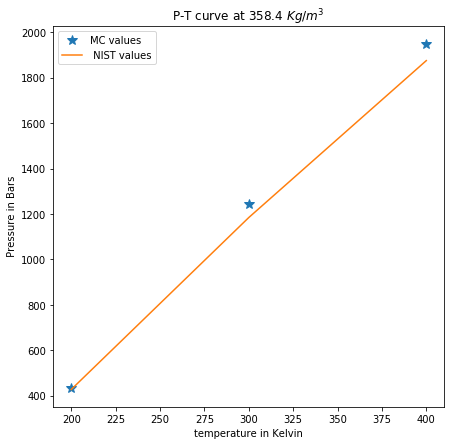

In [126]:
plt.figure(4, figsize = (7, 7))
plt.plot([ 200, 300, 400],[432, 1242, 1950 ], marker = "*", ms = 10, linestyle = '', label ="MC values"); # update these values to get the fresh plot.
plt.plot([ 200, 300, 400],[427, 1184, 1875 ], label =" NIST values");
plt.ylabel(" Pressure in Bars");
plt.xlabel("temperature in Kelvin");
plt.title ("P-T curve at 358.4 $Kg/m^3$ ")
plt.legend()

### Case 2: 

Note: the pressure will be printed below the cells. You need to manually put the three values to update the plot.

In [38]:
def startConf(T, Npart, sigma, epsi, Rcut, Lx, Ly, Lz, step_size, run):
    '''
    Same function as the previous one. 
    Only difference, the minimum distance between particles is increased to 10 angstrom instead of 3.
    '''
    
    traj_coord = [[],[],[]]; # to store the  particle trajectories
    
    part_count = 1;

    #~~~~~~~~~~~~~~~~~~~Create the first Particle~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    seedx = float(Lx/2*ran_num_gen(1));  # ran_num_gen creates a value between -1 to 1 and I scale it to -L/2 to +L/2
    seedy = float(Ly/2*ran_num_gen(1));  # to create a new particle
    seedz = float(Lz/2*ran_num_gen(1));   
        
    traj_coord[0].append(seedx);
    traj_coord[1].append(seedy);
    traj_coord[2].append(seedz);
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    while (part_count <= Npart-1): # -1 taken as we create the first particle outside the loop 
            
        x1 = float(Lx/2*ran_num_gen(1));  # ran_num_gen creates a value between -1 to 1 and I scale it to -L/2 to +L/2
        y1 = float(Ly/2*ran_num_gen(1));  # to create a new particle
        z1 = float(Lz/2*ran_num_gen(1));
            
            
        flag =0;
        for i in range(0,part_count):  
                
            x = traj_coord[0][i-1];
            y = traj_coord[1][i-1];
            z = traj_coord[2][i-1];
            
            d = s.sqrt((x-x1)**2 + (y-y1)**2 + (z-z1)**2);
            
            if (d <= 15): # to maintain a distance of Atleast 15 angtrom 
                flag = 1;    
            
        if (flag == 0):
            # Store the trajectories
            traj_coord[0].append(x1);
            traj_coord[1].append(y1);
            traj_coord[2].append(z1);
            part_count += 1; 
    
    traj_coord = np.array(traj_coord);
    
    # Relax the Structure a bit to remove any coinsiding atoms.
    a = translate_EQ(T, Npart, sigma, epsi, traj_coord, Rcut, Lx, Ly, Lz, step_size,run); 
    return a;

In [39]:
# T = 100 density  = 1.6 N = 362
b1 = Monte_Carlo_NVT_write(362, 100, 3.73, 148*Kb/eps, 50, 182, 182, 182, 2 , 500000,10 ,'ch4_1.6_100');

In [40]:
print("the pressure in atms is", b1[0]*1.013/100000);

the pressure in atms is 0.8395700064612566


In [69]:
# T = 200 density  = 1.6 N = 362
b2 = Monte_Carlo_NVT_write(362, 200, 3.73, 148*Kb/eps, 50, 182, 182, 182, 2 , 500000,1000 ,'ch4_1.6_200');

In [70]:
print("the pressure in atms is", b2[0]*1.013/100000);

the pressure in atms is 2.0214281998354844


In [71]:
# T = 300 density  = 1.6 N = 362
b3 = Monte_Carlo_NVT_write(362, 300, 3.73, 148*Kb/eps, 50, 182, 182, 182, 2 , 500000,1000 ,'ch4_1.6_300');

In [72]:
print("the pressure in atms is", b3[0]*1.013/100000);

the pressure in atms is 2.532795356435806


In [73]:
# T = 400 density  = 1.6 N = 362
b4 = Monte_Carlo_NVT_write(362, 400, 3.73, 148*Kb/eps, 50, 182, 182, 182, 2 , 500000,1000 ,'ch4_1.6_400');

In [74]:
print("the pressure in atms is", b4[0]*1.013/100000);

the pressure in atms is 3.348542835888422


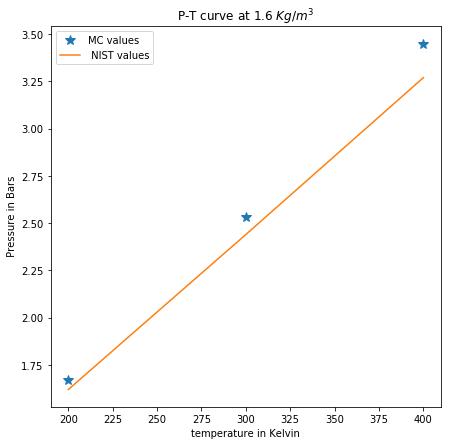

In [121]:
plt.figure(4, figsize = (7, 7))
plt.plot([ 200, 300, 400],[1.67,2.53, 3.45], marker = "*", ms = 10, linestyle = '', label ="MC values"); # update these values to get the fresh plot.
plt.plot([ 200, 300, 400],[1.62, 2.44, 3.27], label =" NIST values");
plt.ylabel(" Pressure in Bars");
plt.xlabel("temperature in Kelvin");
plt.title ("P-T curve at 1.6 $Kg/m^3$ ")
plt.legend()

#### Question Number 4.1

RDF

In [144]:
count  = 0;
xyza = read_xyz_trj("ch4_358.4_100.xyz") 
#number of bins to use for rdf
    
nbins = 149
gr0 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([30,30,30])
# limits to calculate the rdf
rdf_range = (0.10, 15.0)
# loop through frames
for key in xyza.keys():
    r, temp = rdf(xyza[key], L, nbins, rdf_range)
    gr0 += temp
    count +=1
        
gr0 /= len(xyza.keys());    
    
        
count  = 0;
xyzb = read_xyz_trj("ch4_358.4_200.xyz") 
#number of bins to use for rdf
    
nbins = 149
gr = np.zeros(nbins)
# box lenghts as a vector
L = np.array([30,30,30])
# limits to calculate the rdf
rdf_range = (0.10, 15.0)
# loop through frames
for key in xyzb.keys():
    r, temp = rdf(xyzb[key], L, nbins, rdf_range)
    gr += temp
    count +=1
        
gr /= len(xyzb.keys());    
        
count  = 0;
xyzc = read_xyz_trj("ch4_358.4_300.xyz") 
#number of bins to use for rdf
    
nbins = 149
gr1 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([30,30,30])
# limits to calculate the rdf
rdf_range = (0.10, 15.0)
# loop through frames
for key in xyzc.keys():
    r, temp = rdf(xyzc[key], L, nbins, rdf_range)
    gr1 += temp
    count +=1
        
gr1 /= len(xyzc.keys());    

    
    
count  = 0;
xyzd = read_xyz_trj("ch4_358.4_400.xyz") 
#number of bins to use for rdf
    
nbins = 149
gr2 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([30,30,30])
# limits to calculate the rdf
rdf_range = (0.10, 15.0)
# loop through frames
for key in xyzd.keys():
    r, temp = rdf(xyzd[key], L, nbins, rdf_range)
    gr2 += temp
    count +=1
        
gr2 /= len(xyzd.keys());   
        
        

Reach end of 'ch4_358.4_100.xyz'
Reach end of 'ch4_358.4_200.xyz'
Reach end of 'ch4_358.4_300.xyz'
Reach end of 'ch4_358.4_400.xyz'


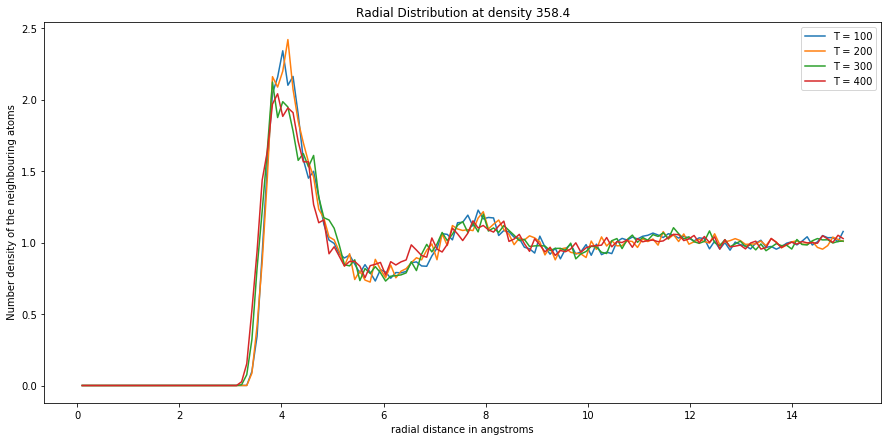

In [146]:
plt.figure(figsize =(15,7));
plt.plot(np.linspace(0.1,15,149),gr0, label  = "T = 100");
plt.plot(np.linspace(0.1,15,149), gr, label  = "T = 200");
plt.plot(np.linspace(0.1,15,149),gr1, label  = "T = 300");
plt.plot(np.linspace(0.1,15,149),gr2, label  = "T = 400");

plt.xlabel("radial distance in angstroms")
plt.ylabel(" Number density of the neighbouring atoms");
plt.title("Radial Distribution at density 358.4");
plt.legend();

In [142]:

count  = 0;
xyz1 = read_xyz_trj("ch4_1.6_100.xyz") 
#number of bins to use for rdf
    
nbins = 80
gr3 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([182, 182, 182])
# limits to calculate the rdf
rdf_range = (0, 80.0)
# loop through frames
for key in xyz1.keys():
    r, temp = rdf(xyz1[key], L, nbins, rdf_range)
    gr3 += temp
    count +=1
gr3 /= len(xyz1.keys());
        
count  = 0;
xyz2 = read_xyz_trj("ch4_1.6_200.xyz") 
#number of bins to use for rdf
    
nbins = 80
gr4 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([182, 182, 182])
# limits to calculate the rdf
rdf_range = (0, 80.0)
# loop through frames
for key in xyz2.keys():
    r, temp = rdf(xyz2[key], L, nbins, rdf_range)
    gr4 += temp
    count +=1
gr4 /= len(xyz2.keys());
        
count  = 0;
xyz3 = read_xyz_trj("ch4_1.6_300.xyz") 
#number of bins to use for rdf
    
nbins = 80
gr5 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([182, 182, 182])
# limits to calculate the rdf
rdf_range = (0, 80.0)
# loop through frames
for key in xyz3.keys():
    r, temp = rdf(xyz3[key], L, nbins, rdf_range)
    gr5 += temp
    count +=1
gr5 /= len(xyz3.keys());
    
    
count  = 0;
xyz4 = read_xyz_trj("ch4_1.6_400.xyz") 
#number of bins to use for rdf
    
nbins = 80
gr6 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([182, 182, 182])
# limits to calculate the rdf
rdf_range = (0, 80.0)
# loop through frames
for key in xyz4.keys():
    r, temp = rdf(xyz4[key], L, nbins, rdf_range)
    gr6 += temp
    count +=1    
gr6 /= len(xyz4.keys())

Reach end of 'ch4_1.6_100.xyz'
Reach end of 'ch4_1.6_200.xyz'
Reach end of 'ch4_1.6_300.xyz'
Reach end of 'ch4_1.6_400.xyz'


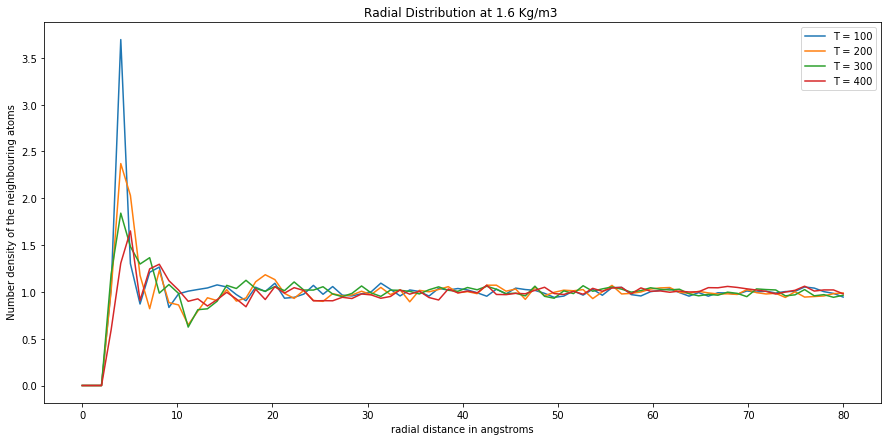

In [143]:
plt.figure(figsize =(15,7));
plt.plot(np.linspace(0,80,80),gr3, label  = "T = 100");
plt.plot(np.linspace(0,80,80),gr4, label  = "T = 200");
plt.plot(np.linspace(0,80,80),gr5, label  = "T = 300");
plt.plot(np.linspace(0,80,80),gr6, label  = "T = 400");

plt.xlabel("radial distance in angstroms")
plt.ylabel(" Number density of the neighbouring atoms");
plt.title("Radial Distribution at 1.6 Kg/m3 ");
plt.legend();